In [5]:
!pip install pyvista

In [1]:
%matplotlib inline
import numpy as np
import shutil
from geoh5py.workspace import Workspace
from discretize import TreeMesh
from geoh5py.objects import Octree, BlockModel
from geoh5py.data import FloatData
from geoapps.inversion import get_inversion_output
from GeoToolkit.Mag import Simulator
from scipy.spatial import cKDTree, Delaunay
from scipy.interpolate import LinearNDInterpolator, griddata
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from geoapps.utils import octree_2_treemesh, find_value, rotate_xy
from shutil import copyfile
import os
from tqdm import tqdm
import qrcode
import pyvista
pyvista.set_plot_theme('document')
pyvista.rcParams['use_panel'] = False

# Batch inversion processing

Notebook for the extraction of isovolumes and sections from a list on inversions.

Fournier & Naylor 2020


In [2]:
root_path = r"."
dsep = os.path.sep
data_file = dsep.join([root_path, "Mag_Albers.geoh5"]) 
inv_path = dsep.join([root_path, "Inversion"])         
workspace = Workspace(data_file)

In [3]:
mag_inv_sites = workspace.get_entity("CAMP_Inversion_site_specs_Dec2020")[0]

geology = workspace.get_entity("CaMP_geounit_classes_no_subunits")[0]

# um_sites = mag_inv_sites.get_data('UmSite')[0].values.tolist()
eastings = mag_inv_sites.vertices[:, 0].tolist()
northings = mag_inv_sites.vertices[:, 1].tolist()

anomaly_inv = mag_inv_sites.get_data("ID")[0].values.tolist()


lower_bound = 0.02
upper_bound = 1.0

(450260.62000000104, 1716722.75)

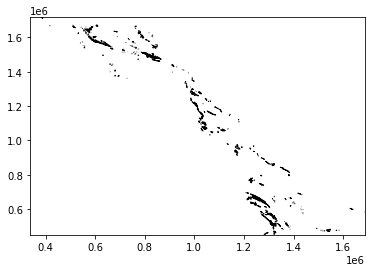

In [4]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

def curve_to_polygons(curve, ax, zorder=10, linewidth=1):
    """
    The a curve object and returns matplotlib.patches.Polygon objects. 
    One object for each parts of the curve.
    """
    
    polygons = []
    for part in curve.unique_parts:
        if not any(curve.parts==part):
            print("empty part", part)
        
        ax.add_patch(Polygon(curve.vertices[curve.parts==part, :2], fill=False, linewidth=linewidth,zorder=zorder))

    return ax
    
  

axs = plt.subplot()
axs = curve_to_polygons(geology, axs)  
axs.set_xlim(geology.vertices[:,0].min(), geology.vertices[:,0].max())
axs.set_ylim(geology.vertices[:,1].min(), geology.vertices[:,1].max())
# axs.set_xlim(ax1.get_xlim())
# axs.set_ylim(ax1.get_ylim())

In [5]:
def get_iso_neighbours(indices, mesh, model, lower_bound, upper):
    
    keeper = []
    if type(indices) == int:
        indices = [indices]
    while indices:
        neighbours = []
        for ind in indices:
            neighbours += mesh[ind].neighbors
        
        neighbours = np.unique(np.hstack(neighbours)).tolist()
        indices = [
            nn for nn in neighbours if (
                (model[nn] > lower_bound) and
                (model[nn] < upper) and
                (nn not in keeper)
            )
        ]
        
        keeper += indices
    return keeper
        

In [6]:
def compute_bounds(bounds, factor):
    # Define a region of interest
    bounds = list(bounds) # COPY IT
    delta = np.array([np.abs(bounds[1] - bounds[0]),
                      np.abs(bounds[3] - bounds[2]),
                      np.abs(bounds[5] - bounds[4])])
    cushion = delta * factor
    bounds[::2] += cushion
    bounds[1::2] -= cushion
    return bounds

def plot_vtki(
    mesh=None, model=None, interactive=False, 
    topo=None, survey=None,
    clim=None, cmap=None, screenshot=False,
    scalar_name='Units', figure_name='figure', 
    plotter=None
):
     
    # Instantiate plotting window
    if plotter is None:
        plotter = pyvista.Plotter(window_size=[800, 400])#notebook=interactive, window_size=[800, 400])
    
    if survey is not None:
        survey_points = pyvista.PolyData(survey['vertices'].copy())
        survey_points.cell_arrays[scalar_name] = survey['values']

        plotter.add_mesh(
            survey_points,  
            render_points_as_spheres=True, 
            point_size=5,
            scalars=scalar_name,
            show_scalar_bar=False,
            cmap='Spectral_r',
    #         clim=[-100,100]
        )
        
        
    if topo is not None:
        # Show input surface topography
        surface = pyvista.PolyData(topo.copy()).delaunay_2d()
#         surface.cell_arrays["Z"] = surface.points[:, 2]
        
#         contours = surface.contour()
        plotter.add_mesh(surface, cmap='gray', opacity=1.)
#         plotter.add_mesh(contours, color="k", line_width=1)
#     survey_points.translate([-val for val in centroid])
#     survey_points.rotate_z(-rotation)
#     survey_points.translate(centroid)
    
    if mesh is not None and model is not None:
#         bounds = [survey[:, 0].min(), survey[:, 0].max(),
#              survey[:, 1].min(), survey[:, 1].max(),
#              survey[:, 2].min()-5000, survey[:, 2].max()
#             ]
#         centroid = np.mean(xyz_local, axis=0)
        # Convert TreeMesh to VTK
        mesh_model = mesh.to_vtk()
    #     mesh_model.clip_box(bounds)

        # Add data values to mesh cells
        mesh_model.cell_arrays[scalar_name] = model
#         mesh_model.cell_arrays['Active'] = actv
#         mesh_model.active_scalars_name = scalar_name

        threshed_values = mesh_model.threshold(lower_bound, scalars=scalar_name)

    
    
    # Remove the inactive cells
#     threshed = mesh_model.threshold(0.5, scalars='Active')
#     threshed.clip_box(bounds, invert=False)
        
    #### Plotting Routine ####
    # Plotting paramaters for data on mesh
        d_params = dict(
                show_edges=False,
                cmap=cmap,
                scalars=scalar_name,
            )
        plotter.add_mesh(mesh_model.outline(), color='k')

#     plotter.add_mesh_slice(mesh_model)
#     plotter.add_mesh_threshold(mesh_model)
        plotter.add_mesh(threshed_values, opacity=.25, clim=[0, lower_bound], show_scalar_bar=False, **d_params)
    
    # Show axes labels
    plotter.show_grid(all_edges=False,)
    
    # Add a bounding box of original mesh to see total extent
    # Clip volume in half
#     plotter.add_mesh(threshed.clip('x', np.r_[600000, 6000000, origin[2]] ), **d_params)

    # Add all the slices
#     slices = threshed.slice_orthogonal(x=centroid[0], y=centroid[1], z=centroid[2]-2000).clip_box(bounds, invert=False)#.clip('z', np.r_[bounds[0], bounds[2], bounds[4]], invert=False)
#     slices.clip_box(bounds, False)
#     plotter.add_mesh(slices, name='slices', clim=[0, 0.1], **d_params)

#     for xx in np.unique(xyz[:,0]).tolist():
#         plotter.add_mesh(threshed.slice('x', np.r_[xx, origin[1], origin[2]]), name='slice %i'%xx, **d_params)
    
#     origin[1] = 5118959

#     single_slice = threshed.slice('y', np.r_[origin[0], 5118959, origin[2]])
#     plotter.add_mesh(single_slice, name='single_slice', **d_params)

#     plotter.export_vtkjs(figure_name)    
#     plotter.camera_position = cpos
#     plotter.show(auto_close=False)
    
#     plotter.close()
    return plotter

In [8]:
links = [
    "https://www.dropbox.com/s/urxmzx7ag51nq8w/Inversion_0.0.vtkjs?dl=0",
    "https://www.dropbox.com/s/r6knllfj0tbw6y6/Inversion_1.0.vtkjs?dl=0",
    "https://www.dropbox.com/s/efmdvprttme80b1/Inversion_2.0.vtkjs?dl=0",
    "https://www.dropbox.com/s/ct4bgti1qptevmd/Inversion_3.0.vtkjs?dl=0",
    "https://www.dropbox.com/s/nmqeakt7snre2s6/Inversion_4.0.vtkjs?dl=0",
    "https://www.dropbox.com/s/bgu16ynlrzqool1/Inversion_5.0.vtkjs?dl=0",
    "https://www.dropbox.com/s/e5bxw0cx473qjme/Inversion_6.0.vtkjs?dl=0",
    "https://www.dropbox.com/s/0takc0k0x72opst/Inversion_7.0.vtkjs?dl=0",
    "https://www.dropbox.com/s/ya7skklztulrwfq/Inversion_8.0.vtkjs?dl=0",
    "https://www.dropbox.com/s/neck7m5ork39yql/Inversion_9.0.vtkjs?dl=0",
    "https://www.dropbox.com/s/s0et7edfsovlgrg/Inversion_10.0.vtkjs?dl=0",
    "https://www.dropbox.com/s/jnkyjzxvxmwsfvy/Inversion_11.0.vtkjs?dl=0",
    "https://www.dropbox.com/s/1w54cayjxuae8c4/Inversion_12.0.vtkjs?dl=0",
    "https://www.dropbox.com/s/d7ta27b73l2gz46/Inversion_13.0.vtkjs?dl=0",
    "https://www.dropbox.com/s/hjf3w5ngjdpwifa/Inversion_14.0.vtkjs?dl=0",
    "https://www.dropbox.com/s/tdho9cd9gm9arqp/Inversion_15.0.vtkjs?dl=0",
    "https://www.dropbox.com/s/0w9p00rvgs982fn/Inversion_16.0.vtkjs?dl=0",
    "https://www.dropbox.com/s/n1edqjclz4tr1ru/Inversion_17.0.vtkjs?dl=0",
    "https://www.dropbox.com/s/9wxzbvf1pmwfplc/Inversion_18.0.vtkjs?dl=0",
    "https://www.dropbox.com/s/23482mwksqc09zk/Inversion_19.0.vtkjs?dl=0",
    "https://www.dropbox.com/s/lgggnq4ziexkmmi/Inversion_20.0.vtkjs?dl=0",
    "https://www.dropbox.com/s/vuycwebzpyozzc7/Inversion_21.0.vtkjs?dl=0",
]

In [9]:
def get_2d_profile(x, y, data, a, b, npts,
                  coordinate_system='local'):
    """
    Plot the data and line profile inside the spcified limits
    """
    def linefun(x1, x2, y1, y2, nx, tol=1e-3):
        dx = x2-x1
        dy = y2-y1

        if np.abs(dx) <= tol:
            y = np.linspace(y1, y2, nx)
            x = np.ones_like(y)*x1
        elif np.abs(dy) <= tol:
            x = np.linspace(x1, x2, nx)
            y = np.ones_like(x)*y1
        else:
            x = np.linspace(x1, x2, nx)
            slope = (y2-y1)/(x2-x1)
            y = slope*(x-x1)+y1
        return x, y

    xLine, yLine = linefun(a[0], b[0], a[1], b[1], npts)

    ind = (xLine > x.min()) * (xLine < x.max()) * (yLine > y.min()) * (yLine < y.max())

    xLine = xLine[ind]
    yLine = yLine[ind]

    distance = np.sqrt((xLine-a[0])**2.+(yLine-a[1])**2.)
    if coordinate_system == 'xProfile':
        distance += a[0]
    elif coordinate_system == 'yProfile':
        distance += a[1]

    if not isinstance(data, list):
        data = [data]

    profiles = []
    for ii, d in enumerate(data):
        if d.ndim == 1:
            dline = griddata(np.c_[x, y], d, (xLine, yLine), method='linear')

        else:
            F = RegularGridInterpolator((x, y), d.T)
            dline = F(np.c_[xLine, yLine])

        # Check for nan
        profiles += [dline]

    return xLine, yLine, profiles

In [12]:
np.linalg.norm(center_local[:2]-cell_location[0, :2])


NameError: name 'center_local' is not defined

Processing: Inversion_20.0
Finished exporting dataset to:  D:\OneDrive - mirageoscience\Projects\MDRU_CMPA\Modeling\Mag\Inversion_20.0.vtkjs
Processing: Inversion_21.0
Finished exporting dataset to:  D:\OneDrive - mirageoscience\Projects\MDRU_CMPA\Modeling\Mag\Inversion_21.0.vtkjs


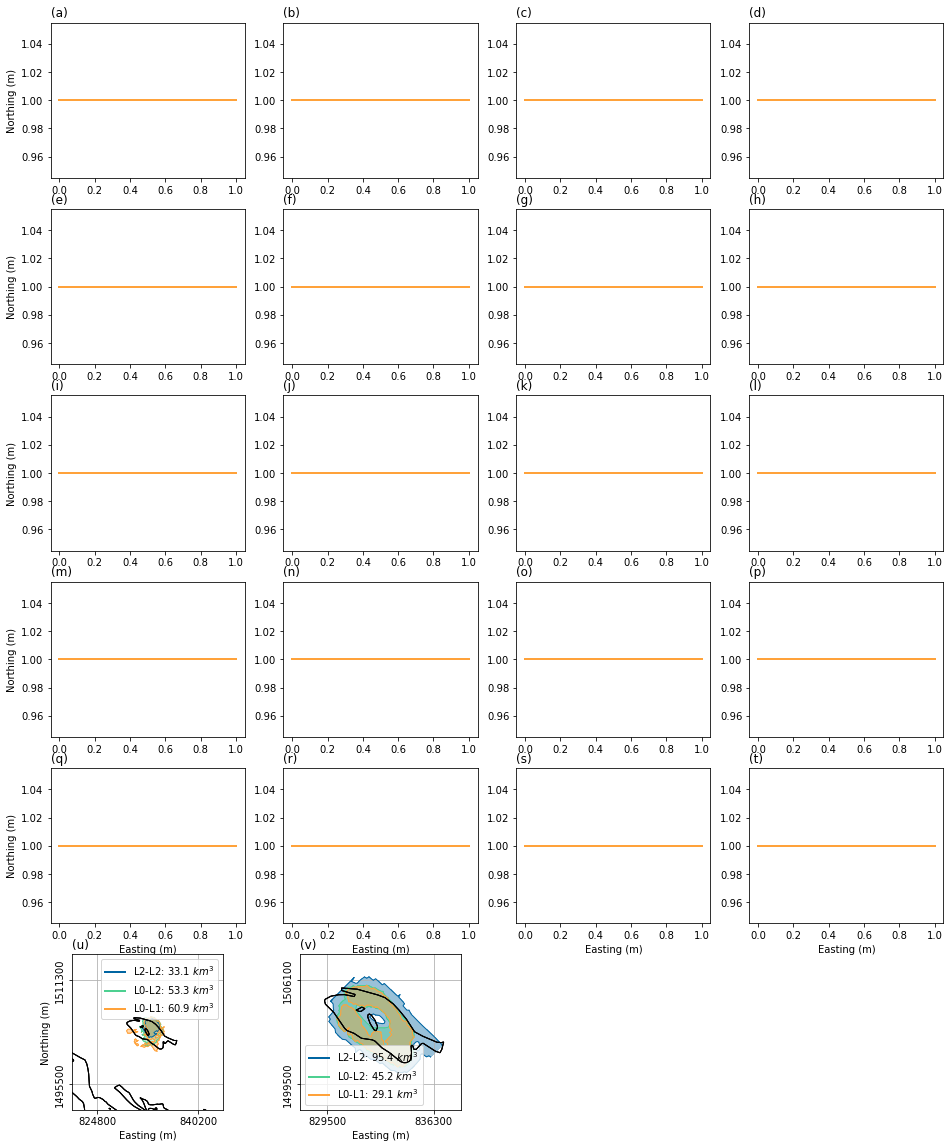

In [15]:

results = {}
cmaps = [
    'GnBu', 'winter', 'summer', 
]
colours = [
    "#0065A2", "#4DD091", "#FFA23A"
]
depth = 1000
data_contours = np.sort(np.unique(np.arange(-500, 5000, 100).tolist() + np.arange(-200, 200, 25).tolist()))
topo_contours = np.arange(0, 2500, 100)
norm_runs = ["L2-L2", "L0-L2", "L0-L1"]
plot = True

# Create figure with 20 subplots for all sites
global_fig = plt.figure(figsize=(16,20))
ax = {}
labels = [
        "(a)", "(b)", "(c)", "(d)", "(e)", 
        "(f)", "(g)", "(h)", "(i)", "(j)", 
        "(k)", "(l)", "(m)", "(n)", "(o)", 
        "(p)", "(q)", "(r)", "(s)", "(t)",
        "(u)", "(v)"
    ]

for inv_id in range(22):
    ax[inv_id] = plt.subplot(6,4,inv_id+1)
    if inv_id % 4 == 0:
        ax[inv_id].set_ylabel("Northing (m)")
    if inv_id > 15:
        ax[inv_id].set_xlabel("Easting (m)")
    
    ax[inv_id].set_title(labels[inv_id], loc="left")
    
    for ii in range(3):
        ax[inv_id].plot([0,1], [1,1], c=colours[ii], linewidth=2)
    
old_um = -1
for inv_id in range(20, 22):
    file = f"Inversion_{inv_id}.0"
    
    
    if plot:
        vtki_plotter = pyvista.Plotter(window_size=[800, 200])#notebook=interactive, window_size=[800, 400])
    print("Processing: " + file)
    file_name = dsep.join([inv_path, file + ".geoh5"])
    workspace = Workspace(file_name)
    
    # Get any of the meshes (should be all the same)
    mesh = workspace.get_entity("Mesh")[0]
    tree = octree_2_treemesh(mesh) # conversion of geoh5 to discretize 
    tree_order = np.empty_like(tree._ubc_order)
    tree_order[tree._ubc_order] = np.arange(len(tree._ubc_order)) # redordering of model values
    names = [child.name for child in mesh.children] #models, [] = in line list
    
    # Load data
    survey = workspace.get_entity(f"Predicted")[0]
    data = survey.get_data(f"Observed_tmi")[0]
    # Load topo and triangulate
    topo_xyz = workspace.get_entity("topo")[0].vertices
        
    if plot:
        x_min, x_max = survey.vertices[:, 0].min(), survey.vertices[:, 0].max()
        y_min, y_max = survey.vertices[:, 1].min(), survey.vertices[:, 1].max()

        x_ticks = np.linspace(x_min, x_max, 7)[1::2]
        x_ticks = (np.round(x_ticks/100) * 100).tolist()
        x_labels = [f"{val:.0f}" for val in x_ticks]

        y_ticks = np.linspace(y_min, y_max, 7)[1::2]
        y_ticks = (np.round(y_ticks/100) * 100).tolist()
        y_labels = [f"{val:.0f}" for val in y_ticks]


        fig = plt.figure(figsize=(16,12))
        ax1 = plt.subplot(2,2,1)
        ax2 = plt.subplot(2,2,2)
        ax3 = plt.subplot(2,2,3)
        ax4 = plt.subplot(2,2,4)
        ax5 = None


        im = Simulator.plotDataHillside(
            survey.vertices[:, 0], survey.vertices[:, 1], data.values, 
            resolution=100, axs=ax1, cmap="Spectral_r", contours=data_contours,
            alpha=0.9, alphaHS=0.25, azdeg=270, altdeg=15, ve=10,
            minCurvature=False
        )
        ax1 = curve_to_polygons(geology, ax1, linewidth=2)     
        ax1.set_aspect('equal')
        ax1.set_title("Observed Data", loc='center')
        ax1.set_title("(a)", loc='left')
        ax1.set_ylabel("Northing (m)")
        ax1.grid(True)
        plt.yticks(rotation='vertical')
        ax1.set_xticks(x_ticks)
        ax1.set_xticklabels(x_labels)
        ax1.set_yticks(y_ticks)
        ax1.set_yticklabels(y_labels, rotation='vertical', va='center')
        cbar = plt.colorbar(im[3], ax=ax1, label="TMI (nT)")
        pos_ref = ax1.get_position()

        im = Simulator.plotDataHillside(
            topo_xyz[:, 0], topo_xyz[:, 1], topo_xyz[:, 2],
            resolution=100, axs=ax2, cmap="terrain", contours=topo_contours,
            alpha=0.9, alphaHS=0.25, equalizeHist="linear", azdeg=270, altdeg=15, ve=10,
            minCurvature=False
        )
        ax2 = curve_to_polygons(geology, ax2, linewidth=2)
        ax2.set_aspect('equal')
        ax2.set_xlim(ax1.get_xlim())
        ax2.set_ylim(ax1.get_ylim())
        ax2.set_title("Topography", loc='center')
        ax2.set_title("(b)", loc='left')
        ax2.set_xlabel("Easting (m)")
        ax2.grid(True)
        ax2.set_xticks(x_ticks)
        ax2.set_xticklabels(x_labels)
        ax2.set_yticklabels([])
        plt.colorbar(im[3], ax=ax2, label='Elevation (m)')
    
    xyz_local = rotate_xy(
        survey.vertices,
        [mesh.origin['x'], mesh.origin['y']],
        -mesh.rotation
    )
    
    center = np.mean(survey.vertices, axis=0)
    center_local = np.mean(xyz_local, axis=0)
    
#     if mesh.rotation > 0:
#         a_a = a_a[::-1, :]
#         a_a_local = a_a_local[::-1, :]
    
#     print(a_a)
#     Simulator.plotProfile2D(
#         topo_xyz[:, 0], topo_xyz[:, 1], topo_xyz[:, 2],
#         a_a[0, :], a_a[1, :],
#         100, ax=ax5, fig=fig, coordinate_system = 'xProfile',
#         linewidth=2, plotStr = ['k']
#     )
    
    topo_local = rotate_xy(
        topo_xyz,
        [mesh.origin['x'], mesh.origin['y']],
        -mesh.rotation
    )
    
    topo_local = topo_local[
        (topo_local[:, 0] > xyz_local[:, 0].min()) *
        (topo_local[:, 0] < xyz_local[:, 0].max()) *
        (topo_local[:, 1] > xyz_local[:, 1].min()) *
        (topo_local[:, 1] < xyz_local[:, 1].max()), :
    ]
    if plot:
        vtki_plotter = plot_vtki(
            survey = {
                "vertices": xyz_local,
                "values": data.values
            },
            topo=topo_local,
            scalar_name='TMI',
            plotter=vtki_plotter
        )
        
    topo = Delaunay(topo_local[:, :2])
    topo_interp = LinearNDInterpolator(topo, topo_local[:, 2])
    
    results[file] = {
        0: {},
        1: {},
        2: {}
    }
    contours = []      
    a_a_local = None
    
    for ii in range(3):
        
        if ii == 3:
            continue
         
        if ii==0:
            inversion_number = file + f"_{1}"
        else:   
            inversion_number = file + f"_{ii-1}"

        if not workspace.get_entity(inversion_number):
            
            continue
        group = workspace.get_entity(inversion_number)[0]
        mesh = [obj for obj in group.children if isinstance(obj, Octree)][0] # octree mesh object
        inversion_output = get_inversion_output(file_name,inversion_number) # reading the comment strings to dictionary
        
        if ii==0:
            last_iteration = [name for name in mesh.get_data_list() if "model" in name and "_s" in name][0]
        else:
            last_iteration = [name for name in mesh.get_data_list() if f"{inversion_output['iteration'][-1]}" in name][0]

        model = mesh.get_data(last_iteration)[0]
        vals = model.values.copy()[tree_order] # Avoid over-writing values on the object
        
        vals[tree.vol >= (tree.hx.min() * 2**3.)**3.] = 0
        # Find the nearest cell within the low_bound
        all_highs = tree.gridCC[vals > lower_bound, :]
        if all_highs.shape[0]==0:
            continue
        
        centroid_indices = []
        dist = np.inf
        for anom_id, anom_inv, easting, northing in zip(anomaly_ids, anomaly_inv, eastings, northings):     

            if plot:
                ax1.scatter(easting, northing, 25, color='k')
                ax2.scatter(easting, northing, 25, color='k')
                ax3.scatter(easting, northing, 25, color='k')
                
            if anom_inv != inv_id:
                continue
            

                
            if plot:
                ax1.scatter(easting, northing, 25, color='r')
                ax2.scatter(easting, northing, 25, color='r')
                ax3.scatter(easting, northing, 25, color='r')
                
            cell_location = rotate_xy(
                np.c_[easting, northing, 635],
                [mesh.origin['x'], mesh.origin['y']],
                -mesh.rotation
            )

            if np.linalg.norm(center_local[:2]-cell_location[0, :2]) < dist:
                target = cell_location
#                 inv = ii
                dist = np.linalg.norm(center_local[:2]-cell_location[0, :2])
                
                
            _, ind = cKDTree(all_highs).query(cell_location)

            start_index = tree._get_containing_cell_index(all_highs[ind[0], :])
            indices = get_iso_neighbours(
                start_index, tree, vals, lower_bound, upper_bound
            )
            
            blob_model = np.zeros_like(vals)
            blob_model[indices] = vals[indices]
            
            if plot and indices:
                vtki_plotter = plot_vtki(
                    mesh=tree,
                    model=blob_model,
                    cmap=cmaps[ii],
                    scalar_name='SI',
                    plotter=vtki_plotter
                )

            # Compute total volume
            blob_vol = sum(tree.vol[indices])
            

            # Compute mass: vol * susc
            mass = sum(tree.vol[indices] * vals[indices])
            
            if ~np.any(indices):
                continue
            
            centroid = np.sum(vals[indices, None] * tree.gridCC[indices, :], axis=0) / np.sum(vals[indices])#indices[np.argmax(vals[indices])]
            centroid_index = tree._get_containing_cell_indexes(centroid)
            
                
            if centroid_index in centroid_indices:
                continue
            
            centroid_indices += [centroid_index]
            centroid_utm = rotate_xy(
                centroid.reshape((1,3)),
                [mesh.origin['x'], mesh.origin['y']],
                mesh.rotation
            )
            
            
            results[file][ii][anom_id] = {
                'volumes': {
                    "all": blob_vol
                },
                'mass': mass,
                'values': vals[indices],
                'indices': indices,
                'seed_local': cell_location,
                'centroid': centroid_utm,
                'centroid_index': centroid_index,
            }

            for level in [500, 1000, 2000, 4000]:
                level_ind = np.where(
                    (topo_interp(tree.gridCC[indices, :2]) - tree.gridCC[indices, 2]) < level
                )[0]
                results[file][ii][anom_id]['volumes'][level] = sum(tree.vol[indices][level_ind])
    
#     dist = np.inf
#     for ii in range(3):
#         # Find the peak of blobs nearest to center
        
#         for aid, anomaly in results[file][ii].items():
            
#             if np.linalg.norm(center_local-anomaly['seed_local']) < dist:
#                 target = aid
#                 inv = ii
#                 dist = np.linalg.norm(center_local-anomaly['seed_local'])
# #             indices += anomaly['indices']
    
    if a_a_local is None:
        ind = tree._get_containing_cell_indexes(target)#results[file][ii][target]["indices"][np.argmax(vals[results[file][ii][target]["indices"]])]
        a_a_local = np.r_[
            np.c_[xyz_local[:,0].min(), tree.gridCC[ind, 1], xyz_local[:,2].mean()], 
            np.c_[xyz_local[:,0].max(), tree.gridCC[ind, 1], xyz_local[:,2].mean()],
        ]

        a_a = rotate_xy(
            a_a_local,
            [mesh.origin['x'], mesh.origin['y']],
            mesh.rotation
        )
        
    for ii in range(3):
        
        if ii == 3:
            continue
         
        if ii==0:
            inversion_number = file + f"_{1}"
        else:   
            inversion_number = file + f"_{ii-1}"

        if not workspace.get_entity(inversion_number):
            
            continue
        group = workspace.get_entity(inversion_number)[0]
        mesh = [obj for obj in group.children if isinstance(obj, Octree)][0] # octree mesh object
        inversion_output = get_inversion_output(file_name,inversion_number) # reading the comment strings to dictionary
        
        if ii==0:
            last_iteration = [name for name in mesh.get_data_list() if "model" in name and "_s" in name][0]
        else:
            last_iteration = [name for name in mesh.get_data_list() if f"{inversion_output['iteration'][-1]}" in name][0]

        model = mesh.get_data(last_iteration)[0]
        vals = model.values.copy()[tree_order] # Avoid over-writing values on the object
        
            
        for anomaly in results[file][ii].values():
            ## Plot sections
            # Query all cells where it slices through
            X,Y = np.meshgrid(
                np.arange(xyz_local[:,0].min(), xyz_local[:,0].max(), 100), 
                np.arange(xyz_local[:,1].min(), xyz_local[:,1].max(), 100)
            )
            
#             depth = topo_interp(centroid.reshape((1,3))[:, :2]) - centroid[2]
            xyz = np.c_[X.flatten(), Y.flatten(), topo_interp(np.c_[X.flatten(), Y.flatten()])-depth]
            ind_slice = np.unique(tree._get_containing_cell_indexes(xyz.tolist()))
        
            blob_model = np.zeros_like(vals)
            blob_model[anomaly['indices']] = vals[anomaly['indices']]
            
            model_slice = blob_model[ind_slice]

            # Rotate coordinates back to world
            slice_locs = rotate_xy(
                            tree.gridCC[ind_slice, :2],
                            [mesh.origin['x'], mesh.origin['y']],
                            mesh.rotation
            )
            tri = Triangulation(slice_locs[:, 0], slice_locs[:, 1])

            if plot:
                ax3.tricontourf(tri, model_slice, [lower_bound, upper_bound], colors=colours[ii], alpha=0.25)
                ax3.tricontour(tri, model_slice, [lower_bound, upper_bound], colors=colours[ii], linewidths=2)
                
                ax[inv_id].tricontourf(tri, model_slice, [lower_bound, upper_bound], colors=colours[ii], alpha=0.4)
                ax[inv_id].tricontour(tri, model_slice, [lower_bound, upper_bound], colors=colours[ii], linewidths=1)
                ax[inv_id].grid(True)
                ax[inv_id] = curve_to_polygons(geology, ax[inv_id])
                ax[inv_id].set_aspect('equal')
                ax[inv_id].set_yticks(y_ticks[::2])
                ax[inv_id].set_yticklabels(y_labels[::2], rotation='vertical', va='center')
                ax[inv_id].set_xticks(x_ticks[::2])
                ax[inv_id].set_xticklabels(x_labels[::2])
                ax[inv_id].set_xlim([x_min, x_max])
                ax[inv_id].set_ylim([y_min, y_max])
                
                plt.figure(fig.number)

                if ax5 is None:
                    pos = ax3.get_position()
                    aspect_ratio = (pos.height/pos.width)**0.5
                    ax5 = plt.axes([pos.x0, pos.y0 - 0.35*aspect_ratio, 0.6, 0.3])
                    
                X,Z = np.meshgrid(
                    np.linspace(a_a_local[0, 0], a_a_local[1, 0], 100), 
                    np.linspace(tree.x0[2], tree.gridCC[:,2].max(), 100)
                )
                xyz = np.c_[X.flatten(), np.ones_like(X).flatten() * np.mean(a_a_local[:, 1]), Z.flatten()]
                ind_yz_slice = np.unique(tree._get_containing_cell_indexes(xyz.tolist()))
                model_slice = blob_model[ind_yz_slice]

#                 if np.any(model_slice > lower_bound):
                # Rotate coordinates back to world
                slice_locs = rotate_xy(
                                np.c_[tree.gridCC[ind_yz_slice, 0], np.ones_like(ind_yz_slice) * np.mean(a_a_local[:, 1]),  tree.gridCC[ind_yz_slice, 2]],
                                [mesh.origin['x'], mesh.origin['y']],
                                mesh.rotation
                )
        
#                 if mesh.rotation > 0 or np.abs(mesh.rotation) > 45:
#                     tri = Triangulation(slice_locs[:, 1], slice_locs[:, 2]) 
#                 else:
                tri = Triangulation(slice_locs[:, 0], slice_locs[:, 2])
                ax5.tricontourf(tri, model_slice, [lower_bound, upper_bound], colors=colours[ii], alpha=0.25)
                ax5.tricontour(tri, model_slice, [lower_bound, upper_bound], colors=colours[ii], linewidths=2)

                
    if plot:      
        ax1.plot(a_a[:, 0], a_a[:, 1], 'k--')
        ax1.text(a_a[0, 0], a_a[0, 1], "A", fontsize=14, va='center', ha='right')
        ax1.text(a_a[1, 0], a_a[1, 1], "A'", va='center', fontsize=14)
        
        ax2.plot(a_a[:, 0], a_a[:, 1], 'k--')
        ax2.text(a_a[0, 0], a_a[0, 1], "A", fontsize=14, va='center', ha='right')
        ax2.text(a_a[1, 0], a_a[1, 1], "A'", va='center', fontsize=14)
        
        ax3.plot(a_a[:, 0], a_a[:, 1], 'k--')
        ax3.text(a_a[0, 0], a_a[0, 1], "A", fontsize=14, va='center', ha='right')
        ax3.text(a_a[1, 0], a_a[1, 1], "A'", va='center', fontsize=14)
        ax3.grid(True)
        pos_ax3 = ax3.get_position()
        ax3.set_xlim([x_min, x_max])
        ax3.set_ylim([y_min, y_max])
        ax3 = curve_to_polygons(geology, ax3, linewidth=2)
        ax3.set_aspect('equal')
        ax3.set_ylabel("Northing (m)")
        ax3.set_xlabel("Easting (m)")
        ax3.set_title("Models", loc='center')
        ax3.set_title("(c)", loc='left')
    #     ax3.set_xticklabels([])
        ax3.set_yticks(y_ticks)
        ax3.set_yticklabels(y_labels, rotation='vertical', va='center')

        ax3.set_xticks(x_ticks)
        ax3.set_xticklabels(x_labels)

    #     plt.sca(ax3)
    #     handles, _ = ax3.get_legend_handles_labels()
    #     plt.legend(handles[1::2], norm_runs)

#         start = np.argmin(a_a[1, 0])
        x_locs, y_locs, profiles = get_2d_profile(
            topo_xyz[:, 0], topo_xyz[:, 1], topo_xyz[:, 2], a_a[0, :], a_a[1, :], 100,
        )

#         if mesh.rotation > 0 or np.abs(mesh.rotation) > 45:
        ax5.plot(x_locs, profiles[0]+50, 'k')
        ax5.plot(x_locs, profiles[0]-depth, 'k--')
        ax5.text(x_locs[0], profiles[0][0]-depth, f"{depth:.0f} m", va='bottom', ha='left', fontsize=14)
        ax5.set_xlim([a_a[:, 0].min(), a_a[:, 0].max()])
        x_ticks = np.linspace(a_a[:, 0].min(), a_a[:, 0].max(), 9)[1::2].tolist()
        ax5.set_xlabel("Easting (m)")
            
#         else:
#             ax5.plot(y_locs, profiles[0]+50, 'k')
#             ax5.plot(y_locs, profiles[0]-1000, 'k--')
#             ax5.text(y_locs[0], profiles[0][0]-1000, "1 km", va='bottom', ha='left', fontsize=14)
#             ax5.set_xlim([a_a[:, 1].min(), a_a[:, 1].max()])
#             x_ticks = np.linspace(a_a[:, 1].min(), a_a[:, 1].max(), 9)[1::2].tolist()
#             ax5.set_xlabel("Northing (m)")
        
        ax5.set_ylim([profiles[0][~np.isnan(profiles[0])].min()-3000, profiles[0][~np.isnan(profiles[0])].max()+100])
        x_labels = [f"{val:.0f}" for val in x_ticks]
        ax5.set_xticks(x_ticks)
        ax5.set_xticklabels(x_labels)
        ax5.set_ylabel("Elevation (m)")
        ax5.grid(True)
#         ax5.set_title("A-A'")
        ax5.set_aspect('equal')
        pos = ax5.get_position()
    

    legend = []
    volumes = []
    for ii, (run, summaries) in enumerate(results[file].items()):

        values = []
        volume = 0
        for anom, result in summaries.items():
            values.append(result['values'])
            volume += result['volumes']['all']
        
        if len(values) == 0:
            continue
            
        if plot:
            hist = ax4.hist(
                np.hstack(values), bins=np.linspace(lower_bound,0.25,50), 
                log=True, alpha=1., fc=colours[ii], ec=colours[ii], fill=False,
                zorder=3-ii, linewidth=2
            )

        volumes += [volume]
        legend.append(f"{norm_runs[ii]}: {volume*1e-9:.1f} $km^3$")
        
#         plt.sca = ax[inv_id]
#         legend.append(f"{norm_runs[ii]}: {volume*1e-9:.1f} $km^3$")
        
    if plot:
        pos = ax4.get_position()
        ax4.set_position([pos.x0, ax3.get_position().y0, ax3.get_position().width*0.75, ax3.get_position().height])
        ax4.set_xlabel("$\kappa_e$")
        ax4.set_ylabel("Cell count")
        ax4.set_title("Model Values", loc='center')
        ax4.set_title("(d)", loc='left')
        
        ax[inv_id].legend(legend)
        
        ax4.legend(legend, bbox_to_anchor=(-0.05, 1), loc='upper right')


        qr = qrcode.QRCode(
            version=1,
            error_correction=qrcode.constants.ERROR_CORRECT_L,
            box_size=10,
            border=4,
        )

        out_path = r"D:\Dropbox\Projects\MDRU_CMPA\Scenes"

        vtki_plotter.export_vtkjs(file)
        shutil.copyfile("./" + file + ".vtkjs", out_path +"\\" + file + ".vtkjs")
        pyvista_url = pyvista.get_vtkjs_url(links[inv_id])
#         vtki_plotter.enable_parallel_projection()

    #     pos = vtki_plotter.show(auto_close=False)
#         pos = np.mean(topo_local, axis=0)
#         pos[2] -= 2000
#         focal = pos.copy()
#         focal[0] += 10000
#     #     vtki_plotter.view_yz(negative=True)
#         vtki_plotter.remove_bounds_axes()

#     #     vtki_plotter.set_position(pos, reset=True)

#         vtki_plotter.camera.Zoom(8)
#         vtki_plotter.show(cpos=[pos, focal, [0,0,1]])

#     #     aa = vtki_plotter.show(auto_close=False)
#         im = vtki_plotter.screenshot()
#         pos = ax3.get_position()

        ax5.set_title("Cross-section A-A'", loc='center', fontsize=14)
        ax5.set_title("(e)", loc='left')
    #     ax5.set_title(f"Median Volume: {np.median(volumes)*1e-9:.1f} $km^3$", loc='right')
    #     ax5.set_xticklabels([])
    #     ax5.set_yticklabels([])
    #     ax4.axis('off')
        pos = ax5.get_position()
    #     ax5.set_position([pos.x0, pos.y0, pos.width*1.5, pos.height*1.5])
        qr.add_data(pyvista_url)
        qr.make(fit=True)

        img = qr.make_image(fill_color="black", back_color="white")

        ax6 = plt.axes([pos.x0+pos.width*0.9, pos.y0, 0.2, 0.2])
        ax6.imshow(img, cmap='binary_r')
        ax6.axis('off')
        ax6.set_title("3D Rendering", loc='center', fontsize=12)
        vtki_plotter.close()
        plt.savefig(file + ".png", bbox_inches='tight', dpi=600)
        
        plt.close(fig)
        
# global_fig.savefig("Depth_sections_ALL.png", bbox_inches='tight', dpi=600)

In [3]:
url = "https://rockcloud.eos.ubc.ca:8443/index.php/s/f7oHXGHyDnGM7Kj/download"

# def convertGitHubURL(url):
#     url = url.replace("https://github.com", "https://rawgit.com")
#     url = url.replace("raw/", "")
#     return url
# def generateViewerURL(dataURL):
#     viewerURL = "http://viewer.pvgeo.org/"
#     return viewerURL + '%s%s' % ("?fileURL=", dataURL)
# generateViewerURL(convertGitHubURL(url))

# pvm.export.getVTKjsURL('github', 'https://github.com/OpenGeoVis/PVGeo/raw/docs/ripple.vtkjs')
pyvista.get_vtkjs_url(url)



'http://viewer.pyvista.org/?fileURL=https://rockcloud.eos.ubc.ca:8443/index.php/s/f7oHXGHyDnGM7Kj/download'

In [17]:
import numpy as np

B = np.random.randn(3, 8, 16)
A = np.random.randn(8, 16)

mask = A > 0

new_rgb = [100, 120, 200]
for ii in range(3):
    B[ii, :, :][mask] = new_rgb[ii]
    


In [18]:
B

    


array([[[-1.58351265e+00, -1.24535335e+00,  1.00000000e+02,
          1.09011984e+00,  6.98653800e-01, -2.50575711e-01,
          8.79954910e-01,  1.00000000e+02,  1.00000000e+02,
          1.00000000e+02,  1.00000000e+02,  7.90706815e-02,
          1.00000000e+02,  1.00000000e+02,  8.79318486e-01,
          1.00000000e+02],
        [-6.77051683e-01,  1.00000000e+02,  1.00000000e+02,
         -1.09073178e-01,  1.45083663e+00,  1.00000000e+02,
         -1.14636614e+00,  1.00000000e+02, -1.13534823e-01,
          1.00000000e+02,  5.94599537e-01, -7.40850958e-01,
          1.00000000e+02,  2.61477979e-01,  1.00000000e+02,
         -6.18284246e-01],
        [ 1.00000000e+02,  1.05763004e+00, -3.96199373e-01,
          4.21779463e-01,  9.85729242e-01,  1.00000000e+02,
          1.00000000e+02,  4.59674952e-02, -2.10220435e+00,
          5.25859108e-01,  1.00000000e+02,  1.00000000e+02,
          1.00000000e+02, -5.37436361e-01,  1.00000000e+02,
          1.00000000e+02],
        [-1.8190525

In [16]:
B[ii, :, :][mask]




array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10.])

In [11]:
total_vol = 0
total_vol_scaled = 0
mins = 0
maxs = 0
print()

f = open("summary.txt","w+")
f.write("Inversion, 500, 1000, 2000, 4000, Full\n")
for file in results.keys():
    
    for ii, (run, summaries) in enumerate(results[file].items()):
        volumes = []
        for level in [500, 1000, 2000, 4000, "all"]:
            values = []
            volume = 0
            for anom, result in summaries.items():
    #             values.append(result['values'])
                volume += result['volumes'][level]
            volumes.append(volume*1e-9)
        f.write(file + norm_runs[run] + ", " + ', '.join(f"{e:.2f}" for e in volumes) + "\n")
#         if len(values) == 0:
#             continue
f.close()
#         volumes += [volume]

#         print(f"{norm_runs[ii]}, {volume*1e-9:.1f}, {volume_scaled*1e-9:.1f}, 0")
     
#     print(f"{file}, {np.min(volumes)*1e-9:.1f}, {np.max(volumes)*1e-9:.1f}, {np.median(volumes)*1e-9:.1f}, {np.std(volumes)*1e-9:.1f}")
#     total_vol += np.median(volumes)
#     mins += np.min(volumes)
#     maxs += np.max(volumes)
#     total_vol_scaled += np.median(volume_scaled)
# print(f"Total, {total_vol*1e-9:.1f}, {mins*1e-9:.1f}, {maxs*1e-9:.1f}")#" $km^3$: Scaled {np.median(total_vol_scaled)*1e-9:.1f} $km^3$")
# print(f"Normalized Total, {total_vol*1e-9:.1f}, {mins*1e-9:.1f}, {maxs*1e-9:.1f}, {total_vol_scaled*1e-9:.1f}")#" $km^3$: Scaled {np.median(total_vol_scaled)*1e-9:.1f} $km^3$")


In [179]:
ax



{0: <matplotlib.axes._subplots.AxesSubplot at 0x1221398d048>,
 1: <matplotlib.axes._subplots.AxesSubplot at 0x122957d0f88>,
 2: <matplotlib.axes._subplots.AxesSubplot at 0x122475ead88>,
 3: <matplotlib.axes._subplots.AxesSubplot at 0x122008b4b08>,
 4: <matplotlib.axes._subplots.AxesSubplot at 0x12211b1bb48>,
 5: <matplotlib.axes._subplots.AxesSubplot at 0x12227e18248>,
 6: <matplotlib.axes._subplots.AxesSubplot at 0x122477bfbc8>,
 7: <matplotlib.axes._subplots.AxesSubplot at 0x122150939c8>,
 8: <matplotlib.axes._subplots.AxesSubplot at 0x122a03d1a48>,
 9: <matplotlib.axes._subplots.AxesSubplot at 0x12227af9b08>,
 10: <matplotlib.axes._subplots.AxesSubplot at 0x12209525048>,
 11: <matplotlib.axes._subplots.AxesSubplot at 0x1220034d888>,
 12: <matplotlib.axes._subplots.AxesSubplot at 0x1220fd8a548>,
 13: <matplotlib.axes._subplots.AxesSubplot at 0x1226b8ddf88>,
 14: <matplotlib.axes._subplots.AxesSubplot at 0x1220388de08>,
 15: <matplotlib.axes._subplots.AxesSubplot at 0x1220fbd4248>,
 1

In [14]:
[1, 3, 4] * 2




[1, 3, 4, 1, 3, 4]

In [104]:
# results[file][ii][anom_id] = {
#                 'volumes': {
#                     "all": blob_vol
#                 },
#                 'mass': mass,
#                 'values': vals[indices],
#                 'indices': indices,
#                 'seed_local': cell_location,
#                 'centroid': centroid_utm,
#                 'centroid_index': centroid_index,
#             }

#             for level in [500, 1000, 2000, 4000]:
#                 level_ind = np.where(
#                     (topo_interp(tree.gridCC[indices, :2]) - tree.gridCC[indices, 2]) < level
#                 )[0]
#                 results[file][ii][anom_id][level] = sum(tree.vol[indices][level_ind])




array([0, 1, 2, 3], dtype=int64)